<center> <img src = "https://emeraldpress.org/wp-content/uploads/2022/04/soccer-leagues-900x504.png" style = "height:420px; width:960px; opacity: 1"/><center/>

# <center> Performance analysis of European top league teams <center/>

In this notebook, we display some of the most used techniques for data visualization, on a football related datasets from
__[Kaggle](https://www.kaggle.com/datasets/vivovinco/20212022-football-team-stats)__.


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler

from matplotlib.patches import Rectangle, PathPatch
from matplotlib.colors import to_rgb
from matplotlib.legend_handler import HandlerTuple

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import from custom library since its located in another directory
import sys  
sys.path.insert(0, '../Scripts/')
from image_tools import Radar

In [2]:
# Load datasets
path = "../Data/"
tm_2022 = pd.read_csv("{}team_stats_2021_2022.csv".format(path), sep=';', encoding='latin-1') 
tm_2023 = pd.read_csv("{}team_stats_2022_2023.csv".format(path), sep=';', encoding='latin-1')

In [3]:
# Define functions for data processing and plotting
def label_rk(rank):
    labels = ["Top 5", "Top 10", "Top 15", "Top 20"]
    RkLg = np.arange(6, 22, 5)
    idx = np.where(rank < RkLg)[0][0]
    return labels[idx]

In [4]:
# Process datasets
data = [tm_2022, tm_2023]
for i in range(2):
   data[i]["Top_Team_Scorer_name"] = data[i]["Top Team Scorer"].apply(lambda x: " ".join(x.split(" ")[:-2]))
   data[i]["Top_Team_Scorer_goals"] = data[i]["Top Team Scorer"].apply(lambda x: x.split(" ")[-1]).astype("int64")
   data[i]["Top_Team_Scorer_contribution"] = data[i]["Top_Team_Scorer_goals"]/data[i]["GF"]
   data[i]["LgRk_label"] = data[i]["LgRk"].apply(label_rk)
   data[i]["GD_xGD_diff"] = data[i]["GD"]- data[i]["xGD"]

tm_2022.rename(columns = {"Pts/G":"Pts/MP"}, inplace=True)
del tm_2022["Top Team Scorer"], tm_2023["Top Team Scorer"]

## Scatter Plots

Scatter plots are a basic and effective method for presenting the spread of data in relation to 2 variables. Such representations not only facilitate the identification of possible patterns, but also reveal the degree of interaction between the variables, namely, the correlation.

This example presents the scoring capacity of the teams with regard to the expected total goals (**xG**) and provides an indicator of the scoring efficiency of every team. In addition, the representation reveals a positive correlation between the two variables and enables us to separate the data into clusters.
<br> An interesting interpretation of the efficiency of the teams reveals that top teams usually convert more goals than what is expected according to the performance indicators. At the other end of the scale, relegation teams tend to be scoring on fewer occasions than expected. That means that top teams, as opposed to bottom teams, can score on more difficult chances, and commit fewer mistakes in easier situations to score.

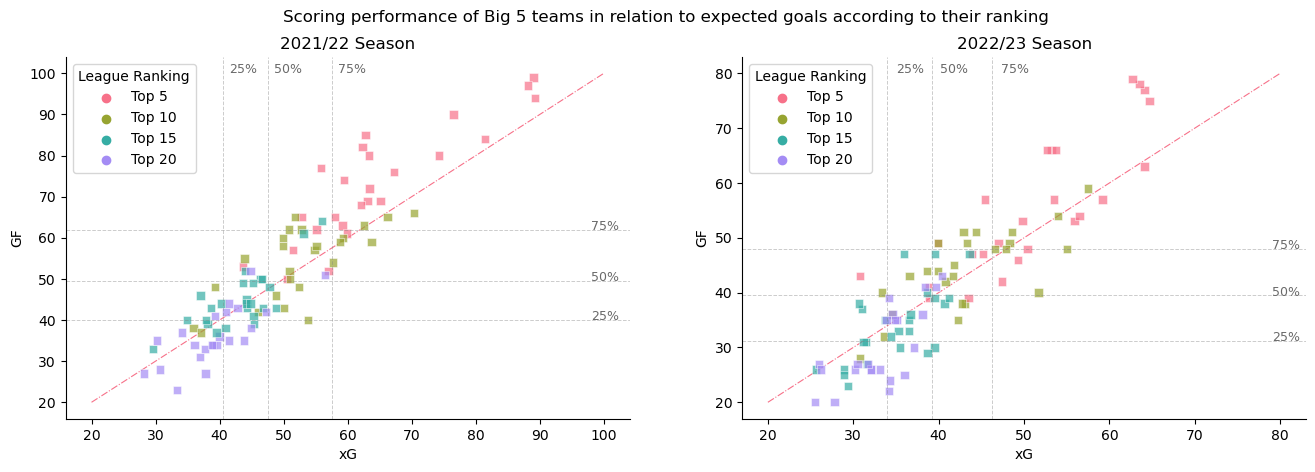

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.7))
data = [tm_2022, tm_2023]
line = [np.linspace(20, 100, 2), np.linspace(20, 80, 2)]
x_text, y_text = [98, 79], [100, 80]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="xG", y="GF", hue="LgRk_label", alpha=0.7, marker="s", legend=True, palette="husl", ax=ax[i], zorder=2)
    ax[i].plot(line[i], line[i], linestyle="-.", linewidth=0.8, zorder=1)
    ax[i].set_title("{} Season".format(title[i]))
    for q in np.arange(0.25, 1, 0.25):
        ax[i].axvline(np.quantile(data[i].xG, q), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
        ax[i].text(np.quantile(data[i].xG, q)+1, y_text[i], f"{int(100*q)}%", size=9, color="dimgrey")
        ax[i].axhline(np.quantile(data[i].GF, q), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
        ax[i].text(x_text[i], np.quantile(data[i].GF, q), f"{int(100*q)}%", size=9, color="dimgrey")
        
    ax[i].legend(title="League Ranking")
        
sns.despine()
plt.suptitle("Scoring performance of Big 5 teams in relation to expected goals according to their ranking")
plt.show()

<br>
A basic plot of the total goals scored and conceded, as presented here, is particularly valuable to identify groupings of clubs based on their standings (in terms of points), despite not being a reliable indicator of the correlation between these variables.
<br><br>

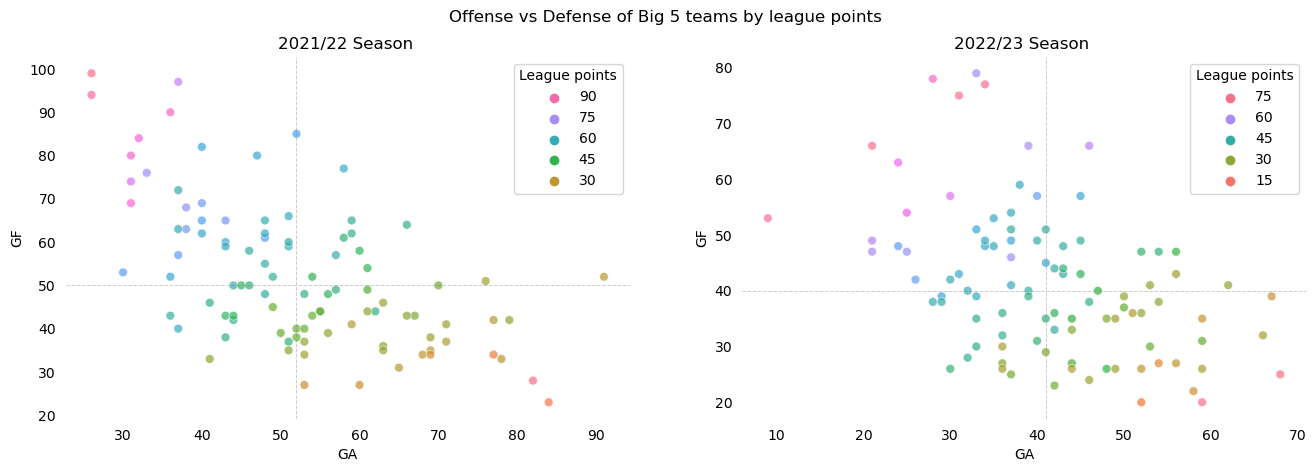

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.7))
data = [tm_2022, tm_2023]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="GA", y="GF", hue="Pts", alpha=0.7, legend=True, palette="husl", s=40, ax=ax[i])
    ax[i].axhline(np.round(np.median(data[i].GF)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].axvline(np.round(np.median(data[i].GA)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title("{} Season ".format(title[i]))
    ax[i].legend(title="League points", reverse=True)

sns.despine(top=True, left=True, bottom=True, right=True)
plt.suptitle("Offense vs Defense of Big 5 teams by league points") 
plt.show()

## Bubble Plots

Bubble plots are an extension of scatter plots that provide a visual representation of a third variable. This representation helps to explore more deeply the relationship between the observed variables, and it's achieved without requiring any additional dimensions to the plot, which simplifies its easy comprehension.

For example, here we show the impact of the contribution of the team's top scorer in relation to the team's ranking and scoring capacity, which is useful for distinguishing between teams that depend heavily on a certain player to provide goals, and teams that have more goal scoring alternatives. 

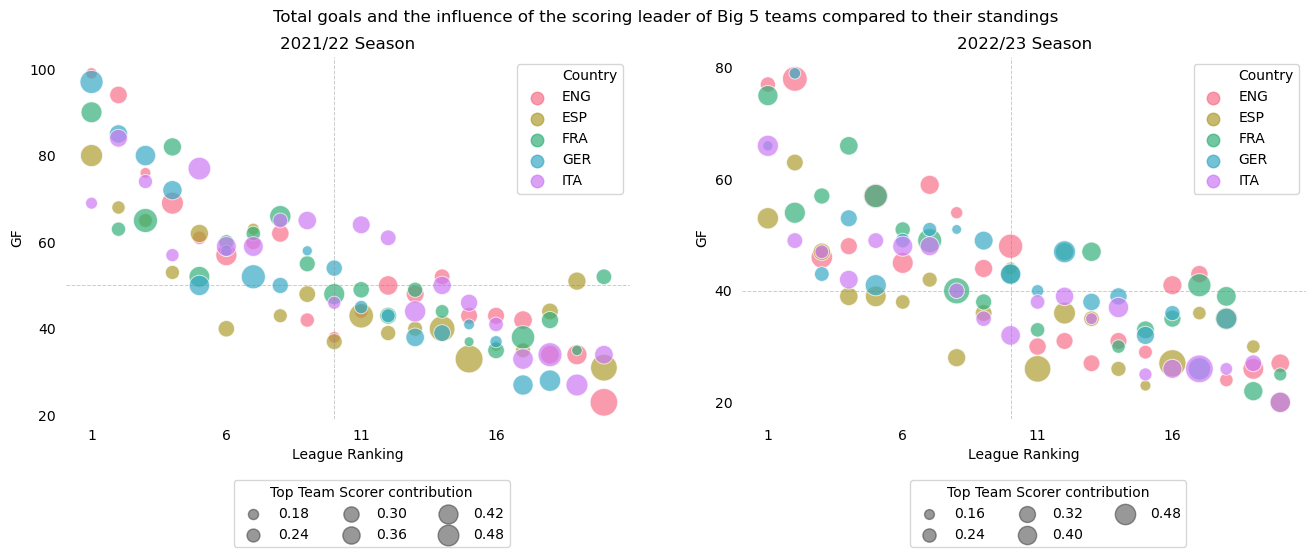

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4.7))
y_ticks = [range(20, 110, 20), range(20, 90, 20)]
data = [tm_2022, tm_2023]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i].sort_values(by="Country"), x="LgRk", y="GF", size="Top_Team_Scorer_contribution", hue="Country", alpha=0.7,
                    legend=True, palette="husl", sizes=(50, 400), ax=ax[i])
    ax[i].set_xticks(range(1, 21, 5), labels=range(1, 21, 5))
    ax[i].set_yticks(y_ticks[i], labels=y_ticks[i])
    ax[i].axvline(10, color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].axhline(np.round(np.median(data[i].GF)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title("{} Season".format(title[i]))
    ax[i].set_xlabel("League Ranking")
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend().remove()
    [hand.set_alpha(0.7) for hand in handles[:6]]
    legend = ax[i].legend(handles=handles[:6], labels=labels[:6], markerscale=1.5, loc="best", ncol=1)
    ax[i].add_artist(legend)
    [hand.set_alpha(0.5) for hand in handles[7:]]
    ax[i].legend(handles=handles[7:], labels=labels[7:], title="Top Team Scorer contribution", markerscale=0.75, 
                 bbox_to_anchor=(0.8, -0.15), ncol=3)
    
sns.despine(top=True, left=True, bottom=True, right=True)
plt.suptitle("Total goals and the influence of the scoring leader of Big 5 teams compared to their standings")
plt.show()

<br>
Different projections can also be used to visualize the same data, as they can highlight patterns that sometimes are not apparent. In this example, one can clearly see the dispersion of the data relative to the league, and moreover, this projection would be much simpler for determining potential clusters.
<br><br>

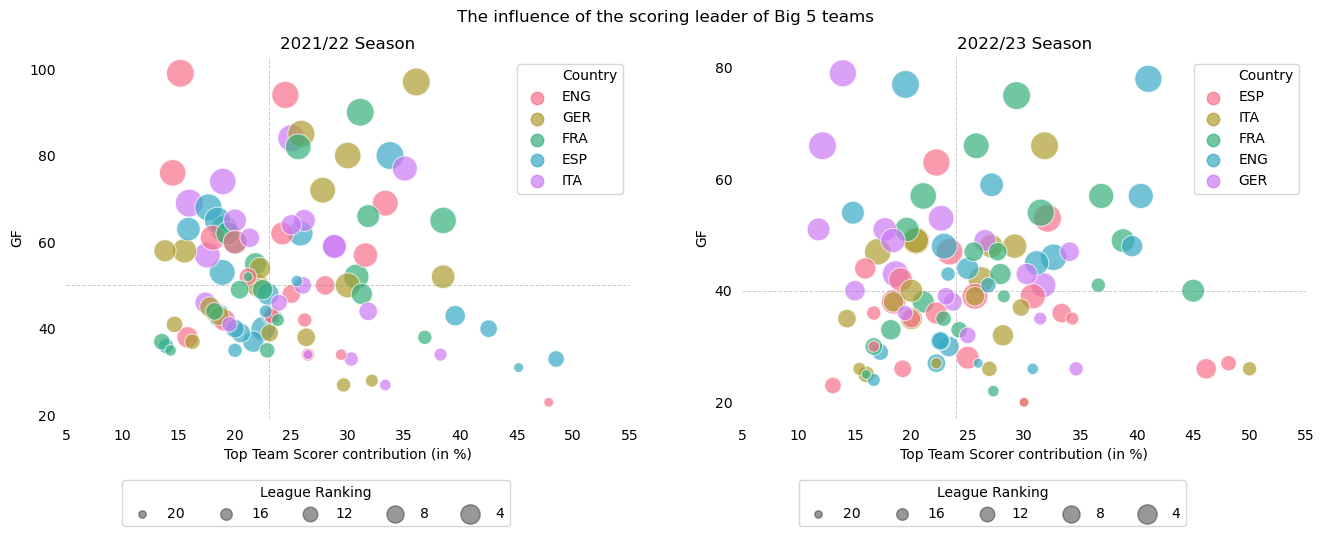

In [86]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4.7))
y_ticks = [range(20, 110, 20), range(20, 90, 20)]
data = [tm_2022, tm_2023]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="Top_Team_Scorer_contribution", y="GF", size="LgRk", 
                    hue="Country", alpha=0.7, legend=True, palette="husl", sizes=(400, 50), ax=ax[i])
    ax[i].set_xticks(np.linspace(0.05, 0.6, 11, endpoint=False), labels=np.linspace(5, 60, 11, endpoint=False).astype(int))
    ax[i].set_yticks(y_ticks[i], labels=y_ticks[i])
    ax[i].axvline(np.round(np.median(data[i].Top_Team_Scorer_contribution), 2), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].axhline(np.round(np.median(data[i].GF)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title("{} Season".format(title[i]))
    ax[i].set_xlabel("Top Team Scorer contribution (in %)")
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend().remove()
    [hand.set_alpha(0.7) for hand in handles[:6]]
    legend = ax[i].legend(handles=handles[:6], labels=labels[:6], markerscale=1.5, loc="best", ncol=1)
    ax[i].add_artist(legend)
    [hand.set_alpha(0.5) for hand in handles[7:]]
    ax[i].legend(handles=handles[7:][::-1], labels=labels[7:][::-1], title="League Ranking", markerscale=0.75, 
                 bbox_to_anchor=(0.8, -0.15), ncol=5)
    
sns.despine(top=True, left=True, bottom=True, right=True)
plt.suptitle("The influence of the scoring leader of Big 5 teams")
plt.show()

<br>
These can be combined with more complex charts. In this case, the size of the bubble gives a direct picture of the impact of the variation in team performance compared to the previous season's ranking, that is, red circles have more relevance within the teams as they become bigger and positioned to the left (worsened performance of the high-table teams), and green circles become more significant within the teams as they become smaller and positioned to the right (improved performance of the low-table teams).
<br><br>

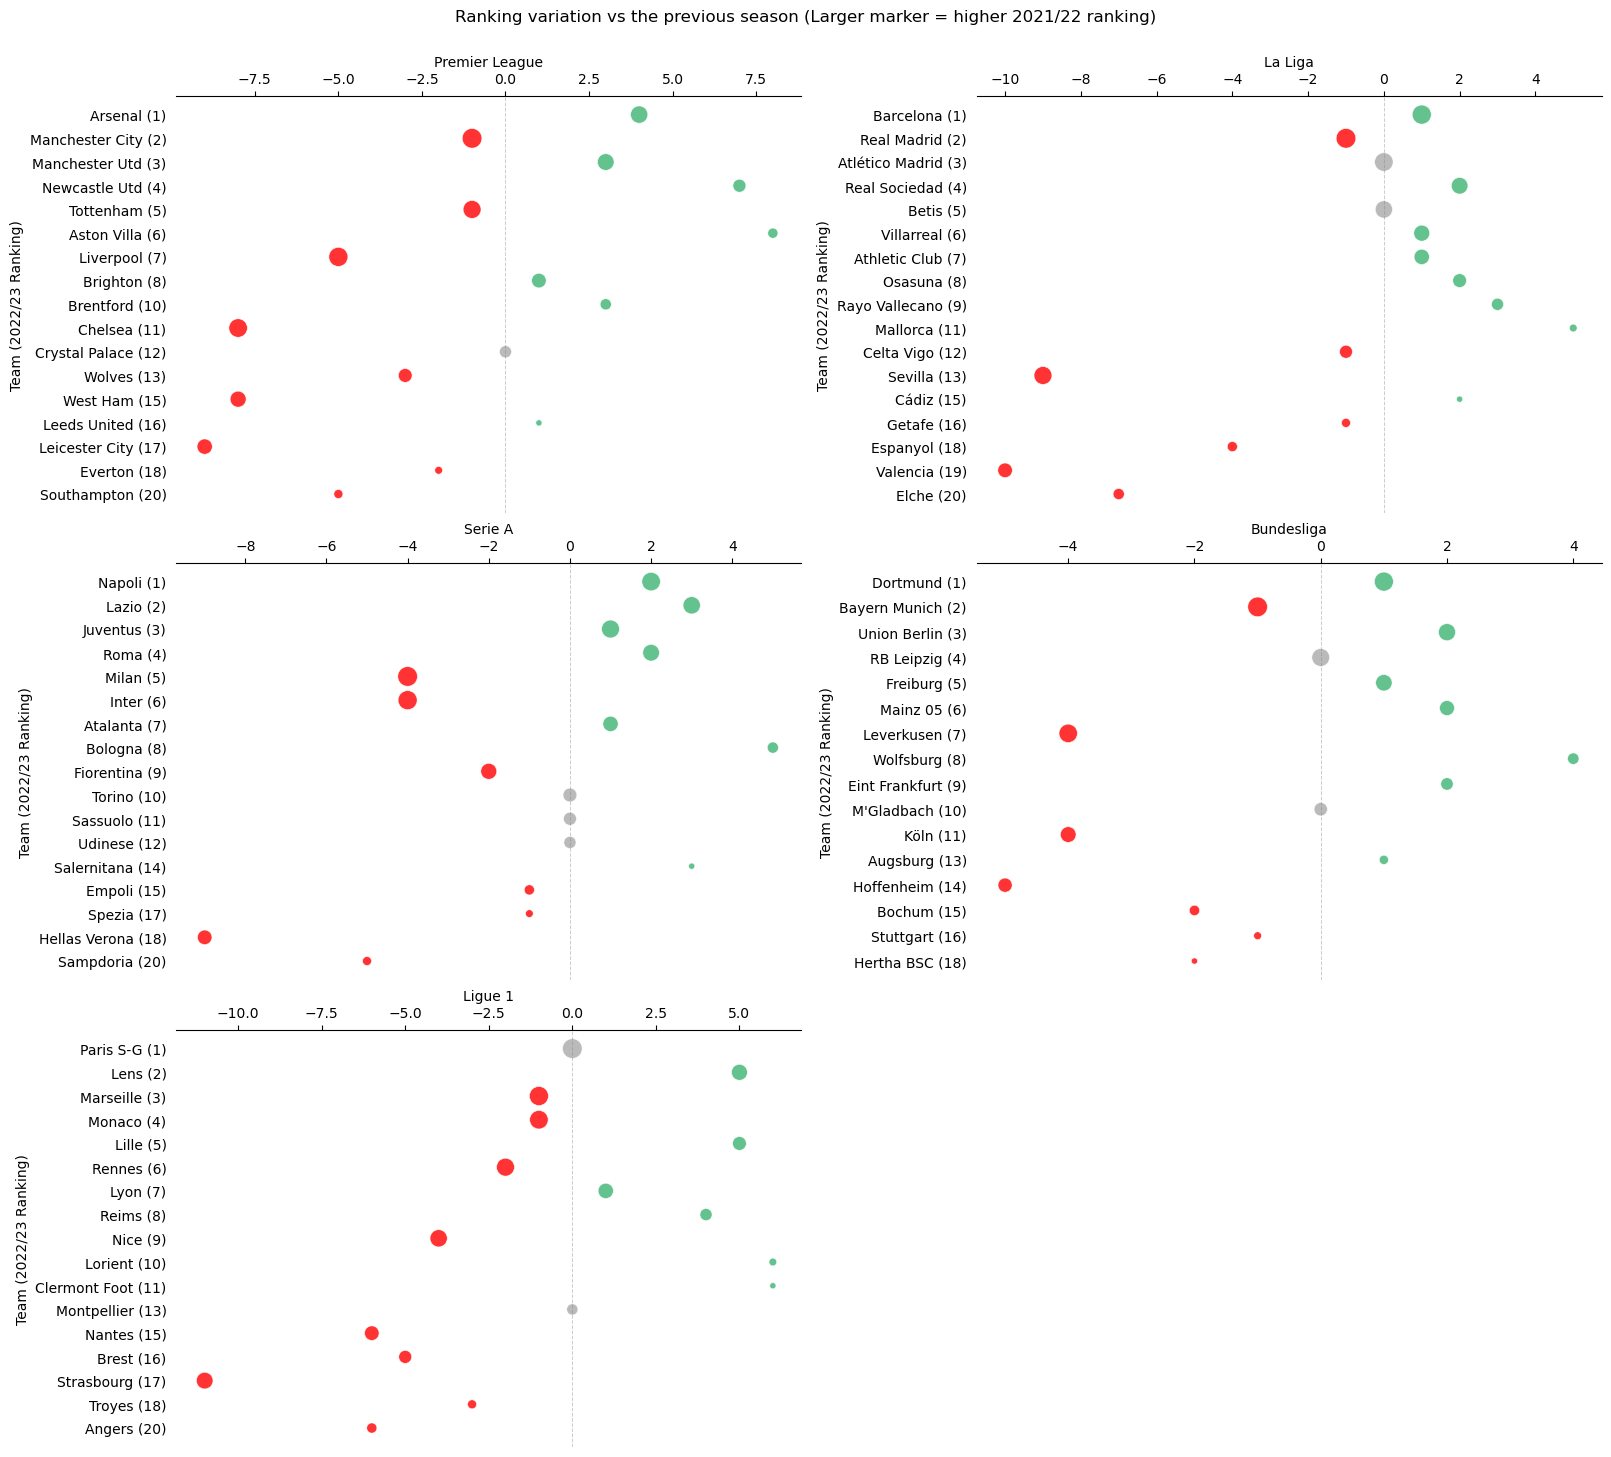

In [48]:
fig, ax = plt.subplots(3, 2, figsize = (16, 14), layout='constrained')
ax[2,1].axis("off")
d_country = {0:['ENG', 'ESP'], 1:['ITA', 'GER'], 2:['FRA']}
d_league = {'ENG': 'Premier League', 'ESP': 'La Liga', 'ITA': 'Serie A', 'GER': 'Bundesliga', 'FRA': 'Ligue 1'}
colors = {-1:"red", 0:"darkgrey", 1:"mediumseagreen"}

for i in range(5):
    country = d_country[i//2][i%2]
    teams_22 = set(tm_2022[tm_2022.Country == country].Squad)
    teams_23 = set(tm_2023[tm_2023.Country == country].Squad)
    rk_2023 = tm_2023[tm_2023.Squad.apply(lambda x: x in (teams_22 & teams_23))].sort_values(by="LgRk").Squad.values
    rk_diff = {squad : tm_2022[tm_2022.Squad==squad].LgRk.iloc[0] - tm_2023[tm_2023.Squad==squad].LgRk.iloc[0] for squad in (teams_22 & teams_23)}
    df_tmp = pd.DataFrame(rk_diff, index = np.arange(1)).T.rename(columns = {0: "Rk_diff"})
    df_tmp["color_enc"] = df_tmp["Rk_diff"].apply(lambda x: 1*(x>0) -1*(x<0))
    df_tmp["Squad"] = df_tmp.index
    df_tmp["Rk_2022_size"] = df_tmp.Squad.apply(lambda x: 500 - 20*tm_2022[tm_2022.Squad==x].LgRk.iloc[0]) # Custom sizes
    df_tmp["Rk_2023_label"] = df_tmp.Squad.apply(lambda x: x + " ({})".format(str(tm_2023[tm_2023.Squad==x].LgRk.iloc[0])))
    
    sns.scatterplot(df_tmp.loc[rk_2023,:], x ="Rk_diff", y="Rk_2023_label", hue="color_enc", legend=False, \
                    palette=colors, alpha=0.8, size='Rk_2022_size', sizes=(20, 200), marker="o", ax=ax[i//2, i%2])
    ax[i//2, i%2].axvline(0, color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i//2, i%2].set_xlabel("{}".format(d_league[country]))
    ax[i//2, i%2].xaxis.set_label_position('top')
    ax[i//2, i%2].set_ylabel("Team (2022/23 Ranking)") 
    ax[i//2, i%2].tick_params(bottom=False, labelbottom=False, top=True, labeltop=True, left=False)
    ax[i//2, i%2].spines[['right', 'left', 'bottom']].set_visible(False)

plt.suptitle("Ranking variation vs the previous season (Larger marker = higher 2021/22 ranking)", y=1.03)
plt.show()
del teams_22, teams_23, rk_diff, df_tmp # remove temporal variables

## Pyramid plot and boxplot

Pyramid plots typically serve to compare population groups, and are particularly effective for highlighting basic characteristics, as well as any dissimilarities between the observed groups.

For their part, boxplots are used to present the distribution of quantitative data and can be interesting for spotting outliers.

The figure above shows a pyramid chart that compares stadium attendances for the 2022 and 2023 seasons. A major difference emerges between the two graphs, showing that in 2023 there is an increase in attendance for major teams, while the minor teams continue to have the same numbers.<br>
Meanwhile, in the figure below, we have a boxplot that gives a deeper insight into this matter and presents a comparative analysis of the evolution of the attendance by league.<br>
In this scenario, both charts complement each other and facilitate a good understanding of the data, while also highlighting peculiar behaviors.

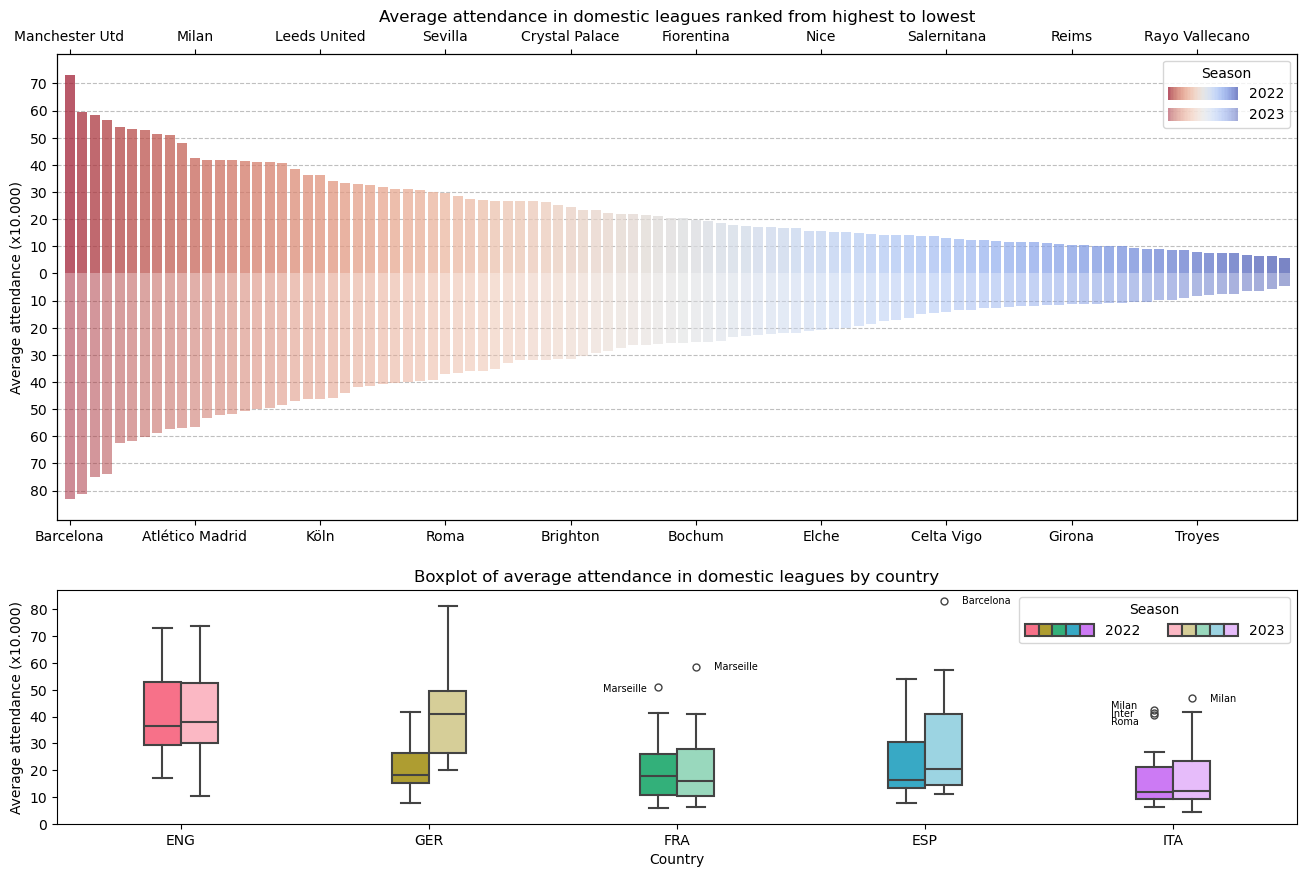

In [90]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1]})
# Upper figure
tm_2023.Attendance = tm_2023.Attendance.apply(lambda x: x*(-1))

sns.barplot(tm_2022.sort_values(by="Attendance", ascending=False), x="Squad", y="Attendance",
            palette="coolwarm_r", alpha=0.75, lw=0, ax=ax[0], zorder=3)

sns.barplot(tm_2023.sort_values(by="Attendance"), x="Squad", y="Attendance", 
            palette="coolwarm_r", alpha=0.52, lw=0, ax=ax[0], zorder=3)

ax[0].set_xticks(range(0, len(tm_2022)+1, 10), labels=tm_2022.sort_values(by="Attendance", ascending=False).Squad.values[::10], rotation = 0)
ax[0].set_yticks(range(-80000, 75000, 10000), labels=list(range(10, 85, 10))[::-1] + list(range(0, 75, 10)))
ax_ = ax[0].twiny()
ax[0].tick_params(labelbottom=False, bottom=False, labeltop=True, top=True)
ax_.tick_params(labelbottom=True, bottom=True, labeltop=False, top=False)
ax_.set_xticks(range(0, len(tm_2023)+1, 10), labels=tm_2023.sort_values(by="Attendance").Squad.values[::10], rotation = 0)
ax[0].set_xlabel("")
ax[0].set_ylabel("Average attendance (x10.000)")
ax[0].set_title("Average attendance in domestic leagues ranked from highest to lowest")
ax[0].set_xlim(-1, len(tm_2022))
ax[0].axhline(0, color="white", linewidth=2)
ax[0].grid(axis='y', linestyle='dashed', alpha=0.8, zorder=0)

ax_.set_xlim(-1, len(tm_2023))
handles = [tuple([p for p in ax[0].patches][98*i:98*(i+1):2]) for i in range(2)]
ax[0].legend(handles=handles, labels = ["2022", "2023"], title="Season", 
              handlelength=5, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})
tm_2023.Attendance = tm_2023.Attendance.apply(lambda x: x*(-1))

tm_2022.insert(0, "Season", 2022)
tm_2023.insert(0, "Season", 2023)

# Lower figure  
df_tmp = pd.concat([tm_2022, tm_2023])
hue_order = ['2022', '2023']
colors = sns.color_palette("husl", 5)

sns.boxplot(df_tmp, x="Country", y="Attendance", hue="Season", width=0.3, saturation=0.5, ax=ax[1], 
            flierprops={"marker": "o", "markerfacecolor":"None"})

# Custom box colors
box_colors = [f + (1 - f) * np.array(to_rgb(c))
              for c in colors for f in np.linspace(0, 0.5, len(hue_order))]

box_patches = [p for p in ax[1].patches if isinstance(p, PathPatch)]

for patch, c in zip(box_patches, box_colors):
    patch.set_facecolor(c)

for collection, color in zip(ax[1].collections, box_colors):
    collection.set_facecolor(color)

# Text annotations for outliers
annotate = {"x": [1.7, 2.15, 3.15, 3.75, 3.75, 3.75, 4.15], 
            "y": [int(x*1000) for x in [49.4, 57.55, 82, 43, 40, 37, 45.7]],
            "s": ["Marseille", "Marseille", "Barcelona", "Milan", "Inter", "Roma", "Milan"]}

for x, y, s in zip(annotate["x"], annotate["y"], annotate["s"]):
    ax[1].text(x=x, y=y, s=s, fontsize=7)

ax[1].set_yticks(range(0, 85000, 10000), labels=range(0, 85, 10))
ax[1].set_ylabel("Average attendance (x10.000)")
ax[1].set_title("Boxplot of average attendance in domestic leagues by country")

handles = [tuple(box_patches[i::len(hue_order)]) for i in range(len(hue_order))]
ax[1].legend(handles=handles, labels=hue_order, title="Season", ncol=2,
          handlelength=5, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

plt.show()

del tm_2022["Season"], tm_2023["Season"]

## Clustering

In [10]:
scaler = StandardScaler()
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
data = pd.DataFrame(scaler.fit_transform(tm_2022[[col for col in tm_2022.columns if col not in \
                ["Rk", "Country", "Squad", "Goalkeeper", "Top_Team_Scorer_name", "LgRk_label"]]]))

X_train_tsne = tsne.fit_transform(data)
X_train_pca = pca.fit_transform(data)

tm_2022[["tsne_A", "tsne_B"]] = X_train_tsne
tm_2022[["pca_A", "pca_B"]] = X_train_pca

In [11]:
%%time
info = {"eps":[], "min_samples":[], "labels":[]}
for eps in np.arange(0.25, 10.25, 0.5):
    for min_samples in range(3, 16):
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
        info["eps"].append(eps)
        info["min_samples"].append(min_samples)
        info["labels"].append(len(set(dbscan_model.labels_)))
info = pd.DataFrame(info)

CPU times: total: 1min 39s
Wall time: 5.64 s


### Heatmap

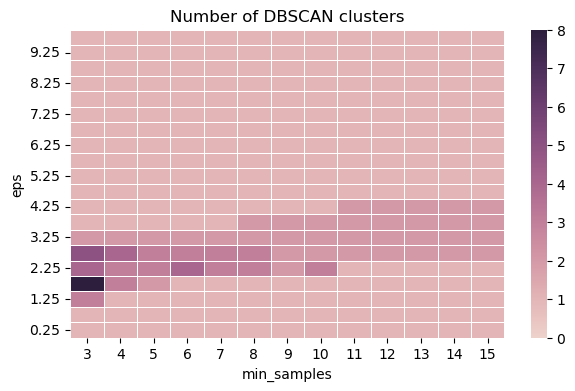

In [12]:
fig, ax = plt.subplots(figsize = (7, 4))
sns.heatmap(info.groupby(["eps", "min_samples"]).max().unstack(level=0).T, cmap=sns.cubehelix_palette(as_cmap=True), 
            vmin=0, vmax=8, linewidth=0.5, linecolor='white', ax=ax)
ax.set_yticks(np.arange(0.5, 20.5)[::2], labels=np.arange(0.25, 10.25, 0.5)[::2])
ax.invert_yaxis()
ax.set_ylabel("eps")
ax.set_title("Number of DBSCAN clusters")
plt.show()

### t-SNE and PCA projections

In [13]:
dbscan_model = DBSCAN(eps=2.75, min_samples=3).fit(data)
kmeans_model = KMeans(n_clusters=4, n_init='auto').fit(data)
pred = kmeans_model.predict(data)
tm_2022["dbscan_labels"] = dbscan_model.labels_
tm_2022["kmeans_labels"] = pred

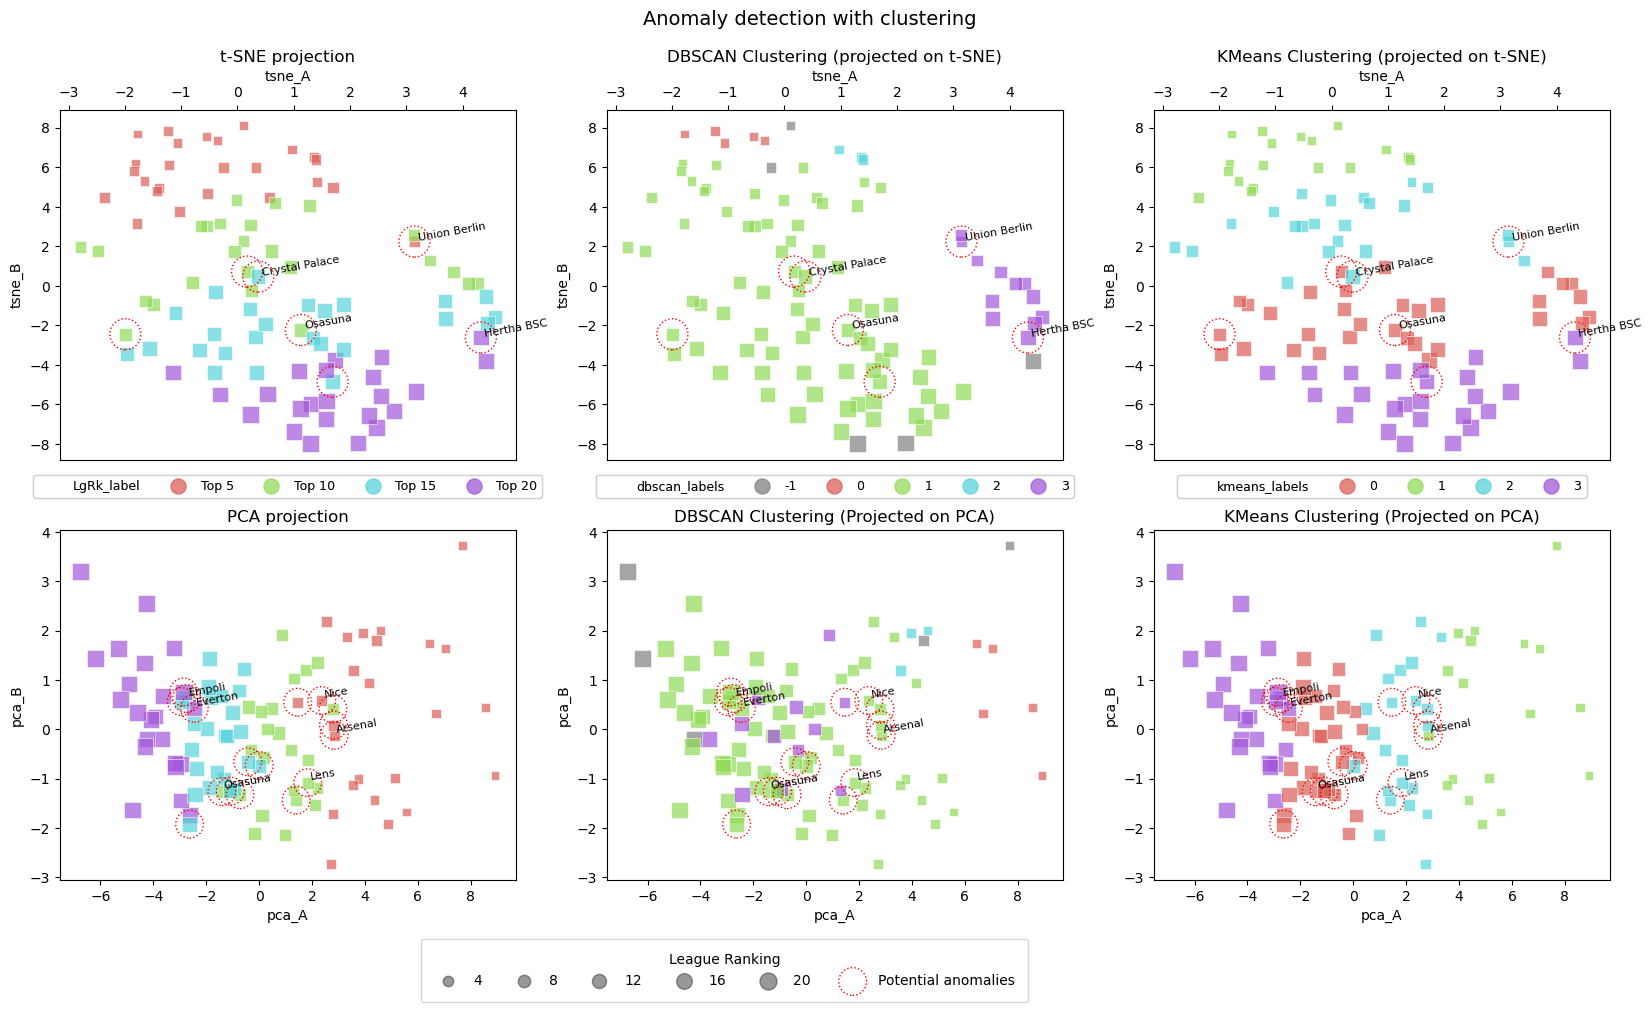

In [14]:
fig, ax = plt.subplots(2, 3, figsize = (20, 10))
# Color palettes
colors = sns.color_palette("hls", 4)
d_color = ["gray"]+[colors[i] for i in range(4)]
palette = ["hls", sns.color_palette(d_color, 5), colors]
# Parameters
anomalies_tsne = ["Union Berlin", "Brighton", "Osasuna", "Wolves", "Crystal Palace", "Southampton", "Hertha BSC"]
anomalies_pca = ["Troyes", "Everton", "Levante", "Sampdoria", "Empoli", "Crystal Palace", "Udinese", "Osasuna", "Wolves", 
                 "Valencia", "Lens", "Real Sociedad", "Union Berlin", "Nice", "Roma", "Betis", "Arsenal"]

X, Y = ["tsne_A", "pca_A"], ["tsne_B", "pca_B"]
h = ["LgRk_label", "dbscan_labels", "kmeans_labels"]
titles = ["t-SNE projection", "DBSCAN Clustering (projected on t-SNE)", "KMeans Clustering (projected on t-SNE)", "PCA projection", 
          "DBSCAN Clustering (Projected on PCA)", "KMeans Clustering (Projected on PCA)"]

for i, ax_ in enumerate(ax.flatten()):
    sns.scatterplot(tm_2022, x=X[i//3], y=Y[i//3], hue=h[i%3], marker="s", size="LgRk", palette=palette[i%3],
                alpha=0.7, sizes=(40, 150), ax=ax_)
    ax_.set_title(titles[i])
    
    if i//3==0:
        # Legend
        ax_.tick_params(labelbottom=False, bottom=False, labeltop=True, top=True)
        ax_.xaxis.set_label_position('top')
        handles, labels = ax_.get_legend_handles_labels()
        ax_.legend().remove()
        [hand.set_alpha(0.7) for hand in handles[:-6]]
        legend = ax_.legend(handles=handles[:-6], labels=labels[:-6], markerscale=1.8, loc='center', 
                                        bbox_to_anchor=(0.5, -0.075), prop={'size': 9}, ncol=6)
        ax_.add_artist(legend)
        [hand.set_alpha(0.5) for hand in handles[-5:]]
        # Annotations
        for j, team in enumerate(anomalies_tsne):
            x, y = tm_2022[tm_2022.Squad == team].tsne_A.values, tm_2022[tm_2022.Squad == team].tsne_B.values
            ax_.scatter(x, y, s=500, facecolors="None", edgecolors="r", linestyle=":", label="Potential anomalies")
            if j%2==0:
                ax_.text(x + 0.05, y + 0.05, team, fontsize=8, rotation=10)
    else:
        # Remove duplicated legend
        ax_.legend().remove()
        # Annotations
        for j, team in enumerate(anomalies_pca):
            x, y = tm_2022[tm_2022.Squad == team].pca_A.values, tm_2022[tm_2022.Squad == team].pca_B.values
            ax_.scatter(x, y, s=400, facecolors="None", edgecolors="r", linestyle=":", label="Potential anomalies")
            if j%3==1:
                ax_.text(x + 0.05, y + 0.05, team, fontsize=8, rotation=10)

anom_h, anom_l = np.array(ax_.get_legend_handles_labels())[:,-1]
ax_.legend(handles=handles[-5:]+[anom_h], labels=labels[-5:]+[anom_l], title="League Ranking", borderpad=1, bbox_to_anchor=(-0.26, -0.15), ncol=6)
plt.suptitle("Anomaly detection with clustering", fontsize=14)
plt.show()

## Radar Plot

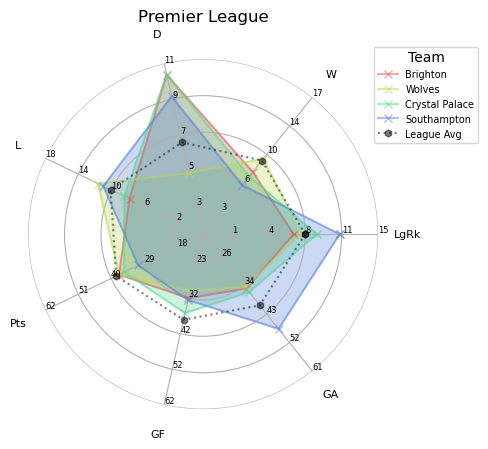

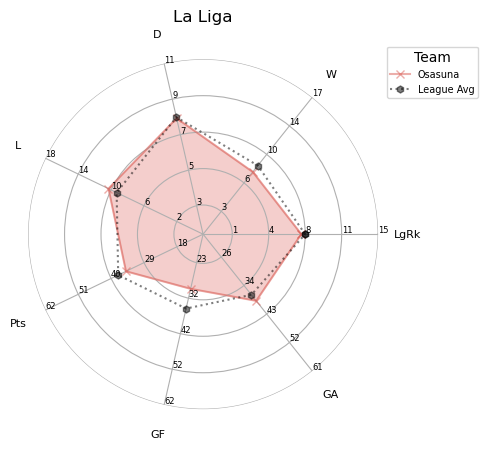

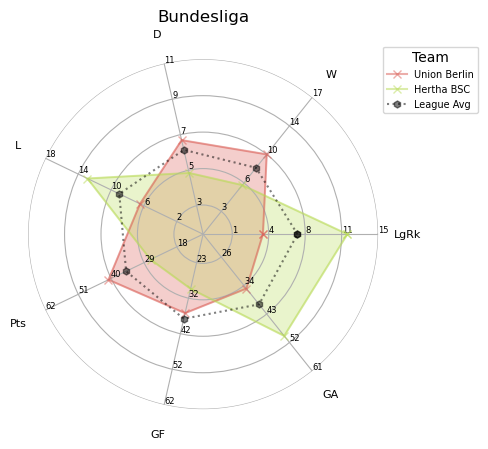

CPU times: total: 1.59 s
Wall time: 2.05 s


In [41]:
%%time
color = "w" #"#EAEAF2"
d_country = {0:['ENG', 'ESP', 'GER']}
league_names = {'ENG':'Premier League', 'ESP':'La Liga', 'GER':'Bundesliga'}
cols =  ["LgRk", "W", "D", "L", "Pts", "GF", "GA"]
to_compare = tm_2022[cols].describe().loc[["min","max"]].values.T
colors = sns.color_palette("hls", 10)
nval=5
anomalies = anomalies_tsne
for i in range(3):
    fig = plt.figure(figsize=(7, 7), facecolor=color)
    country = d_country[0][i]
    df_tmp = tm_2022[tm_2022.Squad.apply(lambda x: x in anomalies) & (tm_2022.Country == country)][cols + ["Squad"]]
    teams = df_tmp.Squad.values
    types = [type(df_tmp.iloc[0, i]) for i in range(len(cols))]
    LABELS = [[np.round(x, 1).astype(types[i]) if x < 100 else np.round(x, -3).astype(types[i]) for x in np.linspace(minval, maxval, nval)] \
              for i, col in enumerate(cols) for (minval, maxval) in zip(tm_2022.describe().loc[["min"], col].values, \
                                                 tm_2022.describe().loc[["75%"], col].values)]
    radar = Radar(fig, cols, LABELS, nval)
    for c, team in enumerate(teams):
        # Team Stats
        VALUES = tm_2022[tm_2022.Squad == team][cols].values.flatten()
        radar.plot(VALUES, to_compare, marker="x", color=colors[2*c], alpha=.5, label=team)
        radar.fill(VALUES, to_compare, color=colors[2*c], alpha=.3, label=team)
    
    # League Stats
    VALUES = tm_2022[tm_2022.Country == d_country[0][i%3]][cols].describe().loc["mean"].values
    radar.plot(VALUES, to_compare, linestyle="dotted", marker="h", markersize=5, color="k", alpha=.5, label="League Avg")
    handles, labels = radar.ax.get_legend_handles_labels()
    radar.ax.legend(title="Team", handles = handles[::2], bbox_to_anchor=(1.3, 1.05), prop={'size': 7}) 
    radar.ax.set_title(league_names[country])
    
plt.show()